# Major Project

### COMP8430 - Advanced Computer Vision and Action

#### Name: Mir Sadia Afrin
#### ID: 47965495

### Phase 1-2: Image Classification using a Pretrained Model on a Fine-Grained Image Dataset

#### __Project Summary:__
In this project, we explored the task of image classification using a pretrained convolutional neural network (CNN) on a fine-grained image dataset. Our dataset is images of different cat breeds.

We are three group members (Sadia, Subhana, Abhi) who contributed to collecting images. We collected 23 selected cat breeds, where each of us collected minimum of 17 images per breed and all together, we collected more than 50 images for each category.

These images are collected from various sources, such as – Pet photos from Friends and Families, Google, CFA official website, Facebook and Instagram. The images are taken from different angles, poses, top views, front views, side views, back views to make the dataset diverse.

The images are sorted into different cat breed folders. There is a labels.csv file with columns - image ID, path, breed name, coat length, and personality.

In future, we plan to add more images under new conditions and environments to improve model accuracy and performance.

__Models:__ For this phase, we have done image classification using a pretrained convolutional neural network (CNN). I have chosen __“ResNet50”__ and __“Inception v3”__ models for this task and I am working on my collected dataset.

## Dataset Preparation

In [ ]:
import pandas as pd
import os

# Reading CSV file
df = pd.read_csv("sadia_labels.csv")

# Normalizing path strings
df["Path"] = df["Path"].str.replace("\\", "/", regex=False)  # Fix Windows backslashes
df["Path"] = df["Path"].apply(lambda p: p + ".jpg" if not p.lower().endswith(".jpg") else p)

# Using the corrected path directly
df["FullPath"] = df["Path"]

# Filtering valid image files
df["Exists"] = df["FullPath"].apply(os.path.exists)
df = df[df["Exists"]].reset_index(drop=True)

# Encoding class labels
class_names = sorted(df["Breed Name"].unique())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
df["Label"] = df["Breed Name"].map(class_to_idx)

# Showing result
print(f"Valid images found: {len(df)}")
print(f"Total classes: {len(class_names)}")
print(df[["Breed Name", "FullPath", "Label"]].head())

Valid images found: 438
Total classes: 23
   Breed Name                                 FullPath  Label
0  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_01.jpg      0
1  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_02.jpg      0
2  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_03.jpg      0
3  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_04.jpg      0
4  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_05.jpg      0


## Dataset Split

In [ ]:
#Splitting the Dataset

from sklearn.model_selection import train_test_split

# Split: 60% train, 10% val, 30% test
train_val_df, test_df = train_test_split(
    df, test_size=0.3, stratify=df["Label"], random_state=42
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1/0.7, stratify=train_val_df["Label"], random_state=42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 262 | Val: 44 | Test: 132


##### Here, the collected dataset has been split into this ratio -
* Training set (60%) - 262 images,
* Validation set (10%) - 44 images and
* Testing set (30%) - 132 images.

In [ ]:
#PyTorch Dataset Class

from torch.utils.data import Dataset
from PIL import Image

class CatBreedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["FullPath"]).convert("RGB")
        label = row["Label"]
        if self.transform:
            image = self.transform(image)
        return image, label

## Model Training

## Pretrained Model Selection

In [ ]:
#Defining Image Transforms

import torchvision.transforms as transforms

# ResNet
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Inception
transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

Separate image preprocessing pipelines are defined for each model:

- **ResNet50** requires images of size 224×224 and uses ImageNet normalization.
- **Inception v3** requires 299×299 images and uses a normalization centered at 0.5.


#### PyTorch DataLoaders are then created for training, validation, and testing.

In [ ]:
#Creating DataLoaders(ResNet & Inception)

from torch.utils.data import DataLoader

# ResNet-compatible transforms
train_ds_resnet = CatBreedDataset(train_df, transform=transform_resnet)
val_ds_resnet = CatBreedDataset(val_df, transform=transform_resnet)
test_ds_resnet = CatBreedDataset(test_df, transform=transform_resnet)

train_loader_resnet = DataLoader(train_ds_resnet, batch_size=32, shuffle=True)
val_loader_resnet = DataLoader(val_ds_resnet, batch_size=32)
test_loader_resnet = DataLoader(test_ds_resnet, batch_size=32)

# Inception-compatible transforms
train_ds_incep = CatBreedDataset(train_df, transform=transform_inception)
val_ds_incep = CatBreedDataset(val_df, transform=transform_inception)
test_ds_incep = CatBreedDataset(test_df, transform=transform_inception)

train_loader_incep = DataLoader(train_ds_incep, batch_size=32, shuffle=True)
val_loader_incep = DataLoader(val_ds_incep, batch_size=32)
test_loader_incep = DataLoader(test_ds_incep, batch_size=32)

In [ ]:
#Defining Pretrained Model Setup Function

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import Inception_V3_Weights, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def setup_model(name):
    if name == "resnet":
        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, len(class_names))

    elif name == "inception":
        weights = Inception_V3_Weights.DEFAULT
        model = models.inception_v3(weights=weights, aux_logits=True)
        model.fc = nn.Linear(model.fc.in_features, len(class_names))

    return model.to(device)

In [7]:
#Training Function

def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    is_inception = isinstance(model, models.Inception3)

    for epoch in range(epochs):
        model.train()
        total, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            if is_inception:
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)

            loss.backward()
            optimizer.step()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                if is_inception and hasattr(outputs, "logits"):
                    outputs = outputs.logits

                preds = torch.argmax(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

## Evaluation & Misclassification Visualization

In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    misclassified.append((img.cpu(), pred.item(), label.item()))

    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")
    return misclassified

import matplotlib.pyplot as plt

def plot_misclassified(misclassified, class_names, num=5):
    plt.figure(figsize=(15, 5))
    for i in range(min(num, len(misclassified))):
        img, pred, true = misclassified[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        plt.subplot(1, num, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
        plt.axis('off')
    plt.show()

#### Evaluation on Test Set

After training, each model is evaluated on the held-out test set. This provides an unbiased measure of how well the model generalizes to unseen data.

#### Misclassified Samples

A subset of misclassified test images is visualized with predicted and actual class labels. This helps identify:

- Patterns in errors
- Similar-looking cat breeds
- Potential dataset limitations

## Train & Evaluate ResNet50

In [9]:
print("Training ResNet50...")
model_resnet = setup_model("resnet")
train_model(model_resnet, train_loader_resnet, val_loader_resnet, epochs=10)

Training ResNet50...
Epoch 1: Train Acc = 0.0840, Val Acc = 0.2955
Epoch 2: Train Acc = 0.8168, Val Acc = 0.4318
Epoch 3: Train Acc = 0.9656, Val Acc = 0.6364
Epoch 4: Train Acc = 0.9847, Val Acc = 0.7273
Epoch 5: Train Acc = 0.9809, Val Acc = 0.7273
Epoch 6: Train Acc = 0.9885, Val Acc = 0.7955
Epoch 7: Train Acc = 1.0000, Val Acc = 0.7955
Epoch 8: Train Acc = 1.0000, Val Acc = 0.7955
Epoch 9: Train Acc = 1.0000, Val Acc = 0.7955
Epoch 10: Train Acc = 1.0000, Val Acc = 0.7500


Evaluating ResNet50...
Test Accuracy: 0.7727


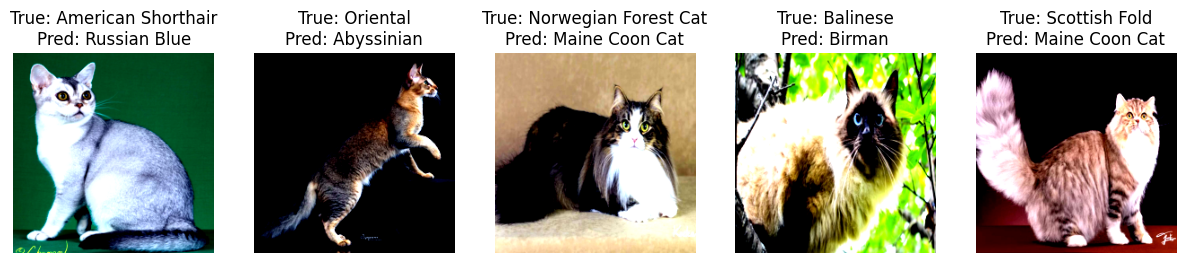

In [10]:
print("Evaluating ResNet50...")
misclassified_resnet = evaluate_model(model_resnet, test_loader_resnet)
plot_misclassified(misclassified_resnet, class_names)

### Training Performance:

- ResNet50 exhibited rapid learning, reaching over 96% training accuracy by epoch 3 and 100% accuracy from epoch 7 onward.

- Validation accuracy increased consistently during early epochs, peaking at 79.5% from epochs 6–9.

- A slight drop to 75.0% in the final epoch suggests early signs of overfitting.

### Evaluation Performance:

- The final test accuracy achieved by ResNet50 was 77.27%, indicating good generalization despite some overfitting.

- Misclassifications mainly occurred between similar-looking breeds:

   * American Shorthair was predicted as Russian Blue

   * Scottish Fold was predicted as Maine Coon Cat

   * Oriental was confused with Abyssinian

### Conclusion:

ResNet50 is fast and powerful for fine-grained classification, but prone to overfitting on small datasets if not regularized.

## Train & Evaluate Inception v3

In [11]:
print("Training Inception v3...")
model_incep = setup_model("inception")
train_model(model_incep, train_loader_incep, val_loader_incep, epochs=10)

Training Inception v3...
Epoch 1: Train Acc = 0.1183, Val Acc = 0.4091
Epoch 2: Train Acc = 0.6412, Val Acc = 0.6364
Epoch 3: Train Acc = 0.9008, Val Acc = 0.6591
Epoch 4: Train Acc = 0.9618, Val Acc = 0.7500
Epoch 5: Train Acc = 0.9656, Val Acc = 0.7727
Epoch 6: Train Acc = 0.9885, Val Acc = 0.7727
Epoch 7: Train Acc = 0.9962, Val Acc = 0.7727
Epoch 8: Train Acc = 1.0000, Val Acc = 0.7955
Epoch 9: Train Acc = 1.0000, Val Acc = 0.7955
Epoch 10: Train Acc = 1.0000, Val Acc = 0.8409


Evaluating Inception v3...
Test Accuracy: 0.7576


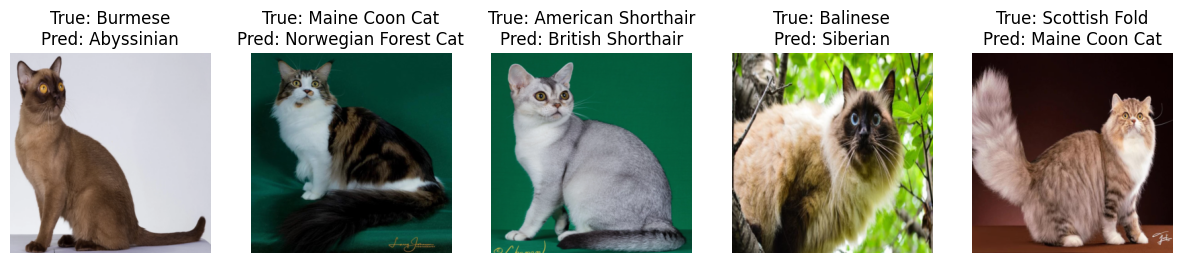

In [12]:
print("Evaluating Inception v3...")
misclassified_incep = evaluate_model(model_incep, test_loader_incep)
plot_misclassified(misclassified_incep, class_names)

### Training Performance:

- Inception v3 showed a more gradual improvement compared to ResNet50.

- Training accuracy reached 90% by epoch 3 and 100% by epoch 8.

- Validation accuracy steadily increased across epochs, reaching a peak of 84.09% in the final epoch — the highest validation score of both models.

### Evaluation Performance:

- Inception v3 achieved a test accuracy of 75.76%, slightly lower than ResNet50, but with better validation consistency.

- Common misclassifications included:

   * Balinese predicted as Siberian

   * Maine Coon Cat predicted as Norwegian Forest Cat

   * Burmese predicted as Abyssinian

### Conclusion:

Inception v3 demonstrated better generalization, with lower risk of overfitting, and achieved more stable validation accuracy than ResNet50.

## Evaluate both models on the test set

Test Accuracy: 0.7727


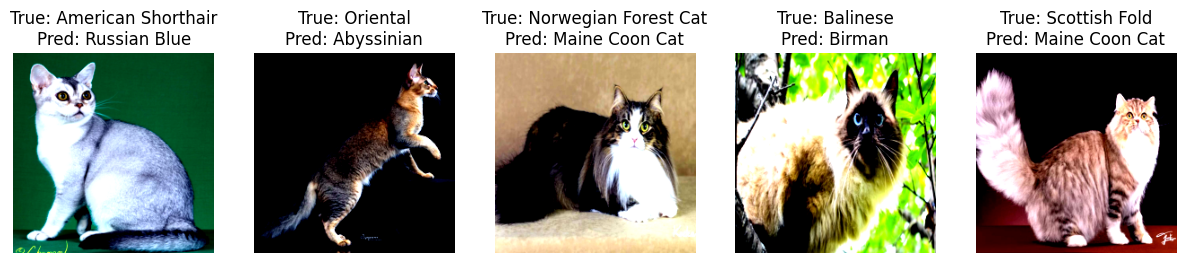

Test Accuracy: 0.7576


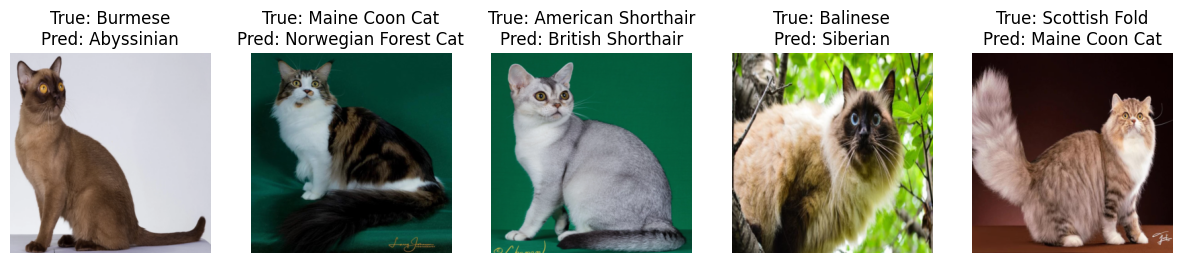

In [13]:
#Evaluate both models on the test set

test_acc_resnet = evaluate_model(model_resnet, test_loader_resnet)
misclassified_resnet = plot_misclassified(misclassified_resnet, class_names)

test_acc_incep = evaluate_model(model_incep, test_loader_incep)
misclassified_incep = plot_misclassified(misclassified_incep, class_names)

In [14]:
torch.save(model_resnet.state_dict(), "resnet50_catbreeds.pth")
torch.save(model_incep.state_dict(), "inceptionv3_catbreeds.pth")

## Overall Model Comparison

- Both models are suitable for fine-grained cat breed classification.

- ResNet50 is faster to train but slightly overfits.

- Inception v3 generalizes better and shows higher validation consistency, making it a more reliable choice on limited datasets.


## Visualisation

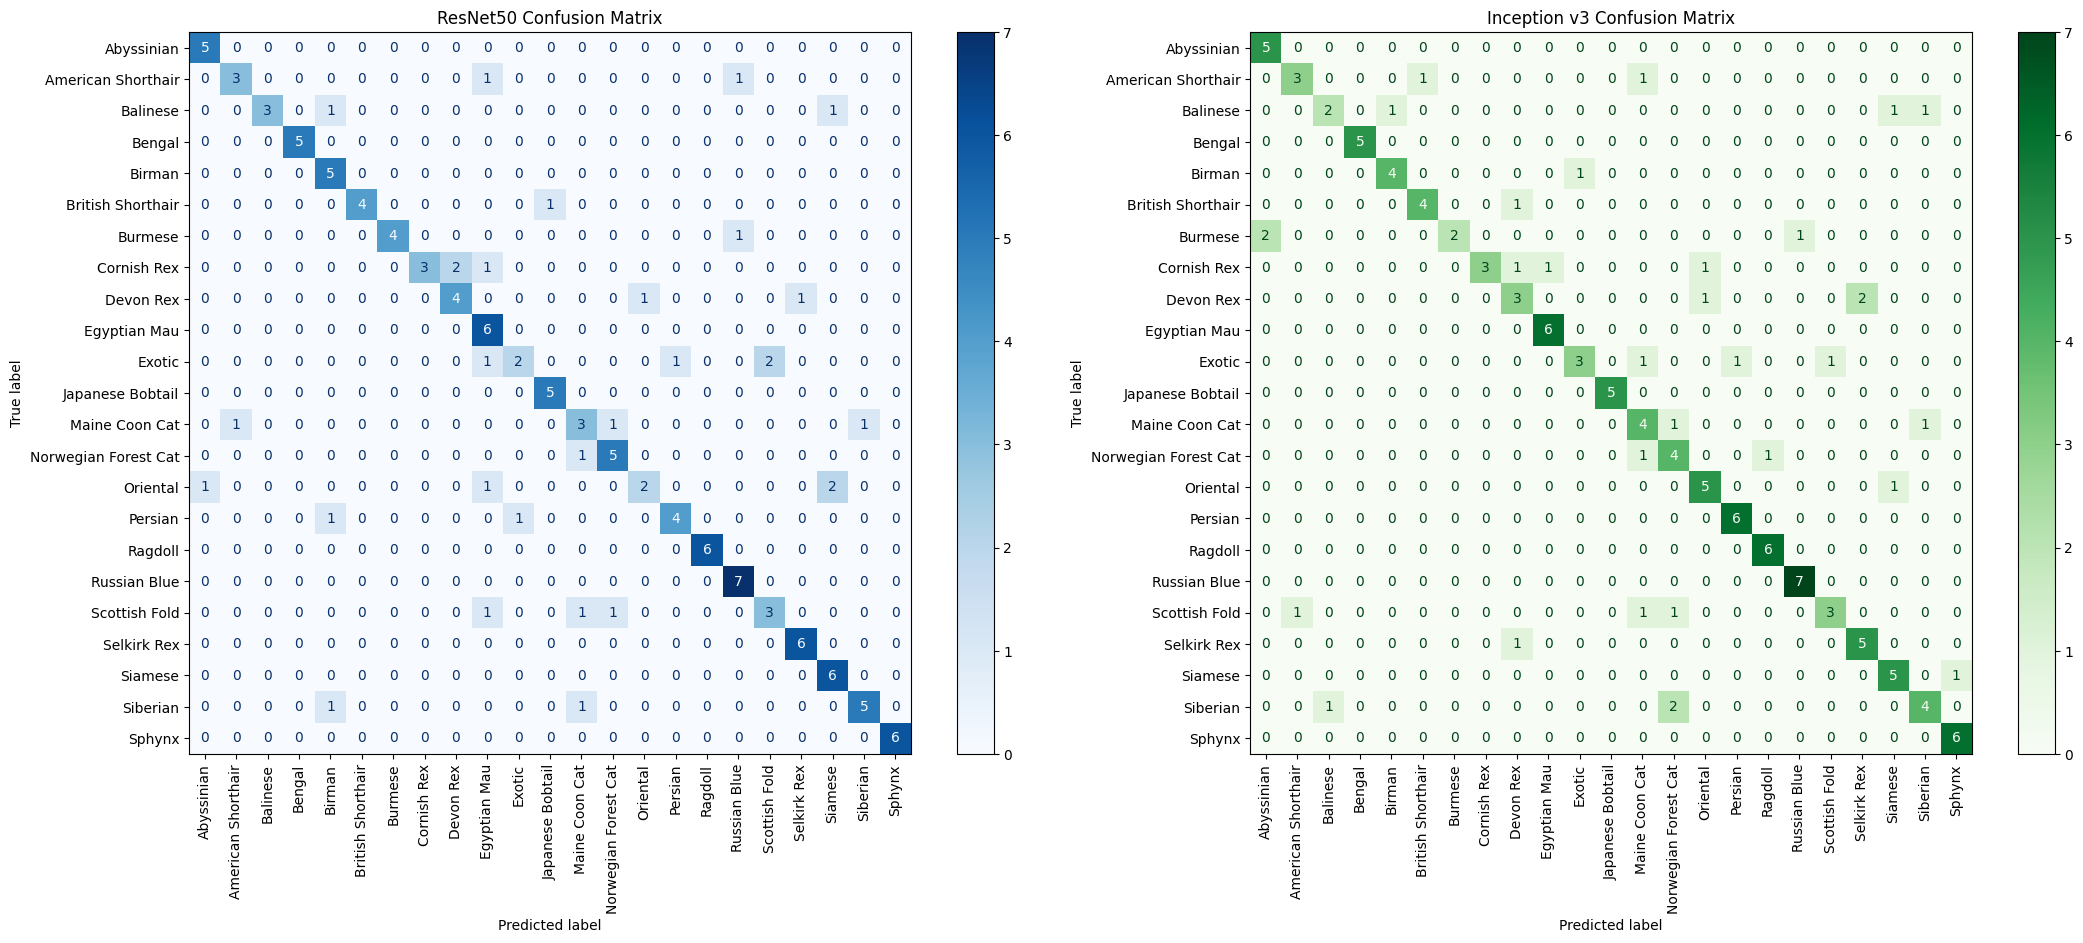

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to get predictions and labels from a test set
def get_preds_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            if hasattr(outputs, "logits"):
                outputs = outputs.logits
            preds = torch.argmax(outputs, 1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# Function to plot both confusion matrices
def plot_confusion_matrices(model_resnet, model_incep, test_loader_resnet, test_loader_incep, class_names):
    preds_resnet, labels_resnet = get_preds_and_labels(model_resnet, test_loader_resnet)
    preds_incep, labels_incep = get_preds_and_labels(model_incep, test_loader_incep)

    cm_resnet = confusion_matrix(labels_resnet, preds_resnet)
    cm_incep = confusion_matrix(labels_incep, preds_incep)

    fig, axes = plt.subplots(1, 2, figsize=(22, 9))

    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=class_names)
    disp1.plot(ax=axes[0], xticks_rotation='vertical', cmap="Blues")
    axes[0].set_title("ResNet50 Confusion Matrix")

    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_incep, display_labels=class_names)
    disp2.plot(ax=axes[1], xticks_rotation='vertical', cmap="Greens")
    axes[1].set_title("Inception v3 Confusion Matrix")

    plt.tight_layout()
    plt.show()

# Run this AFTER both models are trained
plot_confusion_matrices(model_resnet, model_incep, test_loader_resnet, test_loader_incep, class_names)

__A confusion matrix provides a more systematic and quantitative look at model performance across all classes. It is a square grid where:__

- Rows represent the actual classes

- Columns represent the predicted classes

- Diagonal cells show correct classifications

- Off-diagonal cells indicate misclassifications

__Two side-by-side confusion matrices were generated:__

- Left-side for ResNet50

- Right-side for Inception v3

__These visualizations reveal:__

- Which breeds are most frequently confused with each other

- Whether there are systematic weaknesses in the model (e.g., always confusing certain breeds)

- A higher number of values along the diagonal indicates better performance

__Findings:__

- Both models achieve strong diagonal dominance, meaning most predictions are correct.

- A few breeds (e.g., Egyptian Mau, American Shorthair, Maine Coon) appear more frequently in misclassifications, possibly due to subtle differences in their appearance.

## Classification Report (Precision, Recall, F1-Score)

In [17]:
from sklearn.metrics import classification_report

# For ResNet
preds_resnet, labels_resnet = get_preds_and_labels(model_resnet, test_loader_resnet)
report_resnet = classification_report(labels_resnet, preds_resnet, target_names=class_names)
print("ResNet50 Classification Report:\n")
print(report_resnet)

# For Inception
preds_incep, labels_incep = get_preds_and_labels(model_incep, test_loader_incep)
report_incep = classification_report(labels_incep, preds_incep, target_names=class_names)
print("Inception v3 Classification Report:\n")
print(report_incep)

ResNet50 Classification Report:

                      precision    recall  f1-score   support

          Abyssinian       0.83      1.00      0.91         5
  American Shorthair       0.75      0.60      0.67         5
            Balinese       1.00      0.60      0.75         5
              Bengal       1.00      1.00      1.00         5
              Birman       0.62      1.00      0.77         5
   British Shorthair       1.00      0.80      0.89         5
             Burmese       1.00      0.80      0.89         5
         Cornish Rex       1.00      0.50      0.67         6
           Devon Rex       0.67      0.67      0.67         6
        Egyptian Mau       0.55      1.00      0.71         6
              Exotic       0.67      0.33      0.44         6
    Japanese Bobtail       0.83      1.00      0.91         5
      Maine Coon Cat       0.50      0.50      0.50         6
Norwegian Forest Cat       0.71      0.83      0.77         6
            Oriental       0.67     

__Classification Report:__
- Both models achieve solid precision and recall across most breeds

- Inception v3 shows more balanced performance and less overfitting

- Misclassifications mostly involve breeds that are visually similar, which is typical in fine-grained classification tasks

- F1-scores highlight that the models are not just accurate but also fair across classes, with few biases toward dominant breeds